# <div style="background-color: lightblue; padding: 8px;">Melanoma Detection Assignment</div>

## Introduction:
- In this assignment, you will build a multiclass classification model using a custom convolutional neural network in TensorFlow..

## Problem Statement
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

Actinic keratosis
Basal cell carcinoma
Dermatofibroma
Melanoma
Nevus
Pigmented benign keratosis
Seborrheic keratosis
Squamous cell carcinoma
Vascular lesion


### Mount Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


## Importing libraries and packages

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras.models import Sequential
# Import the load_img function from Keras for loading images
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers, models
# Import the Adam optimizer from Keras for optimization during model training
from tensorflow.keras.optimizers import Adam

# Import specific callback functions from Keras for model training callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Data reading and understanding

In [ ]:
# Defining the path for train and test images
## Paths of train and test dataset on Google drive

data_dir_train = pathlib.Path("/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

# List the files in the training set and test set
print(f"Training files: {list(data_dir_train.glob('*'))}")
print(f"Testing files: {list(data_dir_test.glob('*'))}")


Training files: [PosixPath('/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion'), PosixPath('/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma'), PosixPath('/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus'), PosixPath('/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma'), PosixPath('/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis'), PosixPath('/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis'), PosixPath('/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma'), PosixPath('/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic kerato

In [ ]:
# Count the number of images in the training directory
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
# Print the count of images in the training directory
print("Number of images in the training directory:", image_count_train)

# Count the number of images in the test directory
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
# Print the count of images in the test directory
print("Number of images in the test directory:", image_count_test)

Number of images in the training directory: 2284
Number of images in the test directory: 128


Found 8284 files belonging to 9 classes.


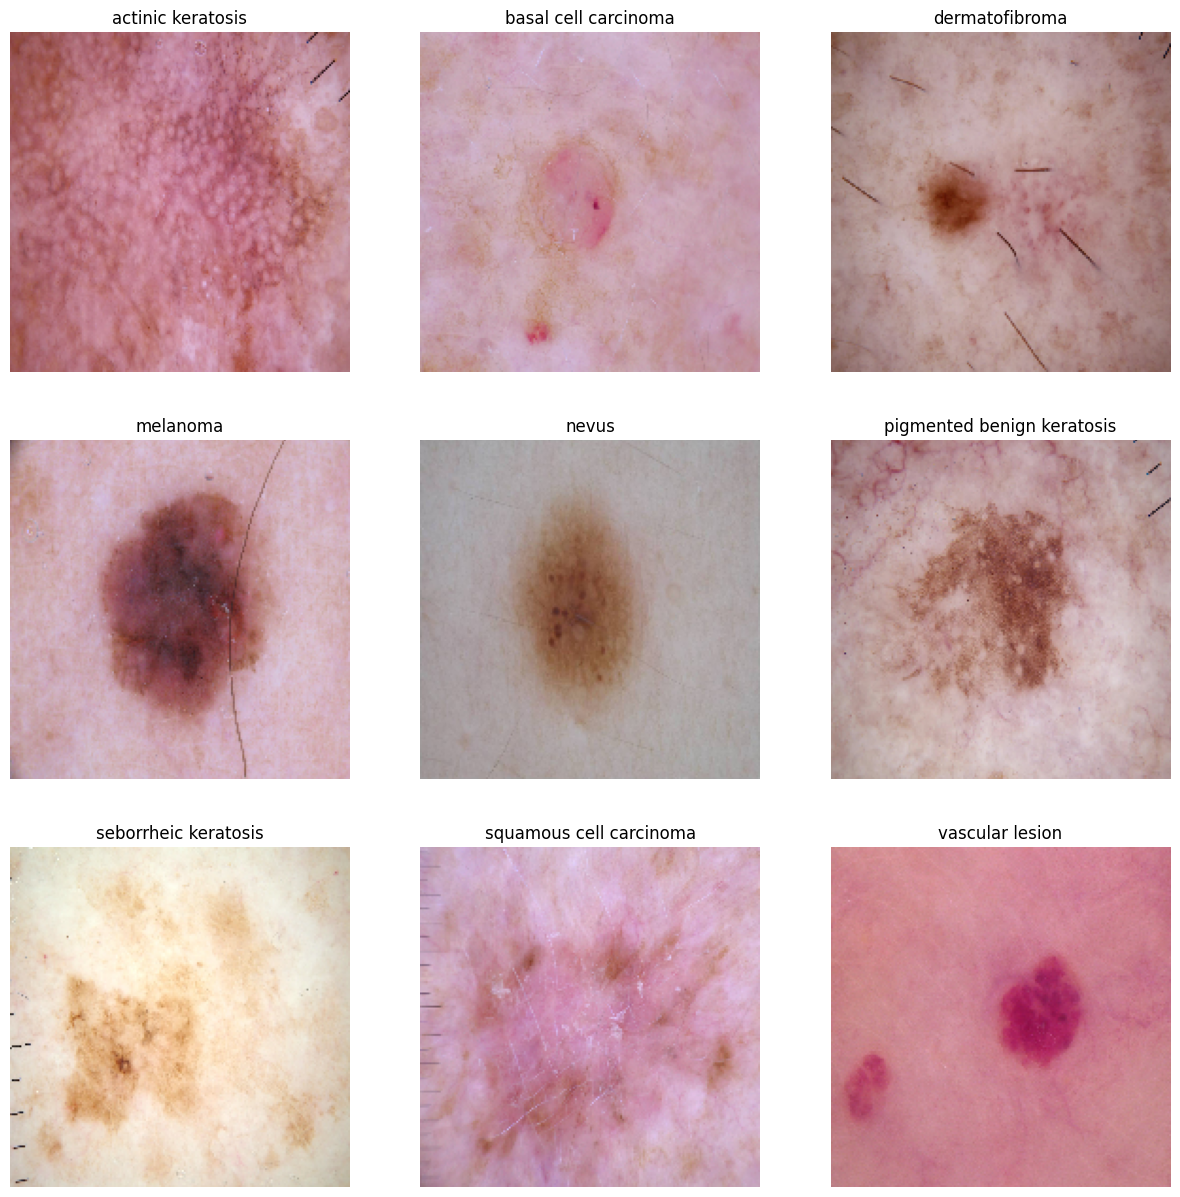

In [7]:
# Visualizing One Instance from Each Class in the Dataset

# Using image_dataset_from_directory() to create a dataset that yields batches of labeled images
# label_mode is set to 'categorical' for one-hot encoding of class labels
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=32, image_size=(180, 180), label_mode='categorical', seed=123
)

# Get the names of all the classes (skin cancer types)
class_names = image_dataset.class_names

# Dictionary to store image paths for each class
files_path_dict = {}

# Loop through each class to gather image paths
for c in class_names:
    files_path_dict[c] = list(map(lambda x: str(data_dir_train) + '/' + c + '/' + x, os.listdir(str(data_dir_train) + '/' + c)))

# Visualize an image from each class
plt.figure(figsize=(15, 15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3, 3, index)

    # Load and display the image
    plt.imshow(load_img(path_list[0], target_size=(180, 180)))
    plt.title(c)
    plt.axis("off")

In [8]:
# Define a function to count and analyze the distribution of images in each class

def class_distribution_count(directory):
    # Initialize a list to store image counts for each class
    count = []

    # Count the number of images in each class directory
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))

    # Get the names of the classes (sub-directories)
    sub_directory = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

    # Create a DataFrame with class names and corresponding image counts
    df = pd.DataFrame(list(zip(sub_directory, count)), columns=['Class', 'No. of Images'])

    # Sort the DataFrame in ascending order of image counts
    df = df.sort_values(by='No. of Images', ascending=True)

    # Return the sorted DataFrame
    return df

# Call the function to get the class distribution and image count
class_distribution_df = class_distribution_count(data_dir_train)

# Display the DataFrame
class_distribution_df

,Class,No. of Images
7,seborrheic keratosis,77
8,dermatofibroma,95
5,actinic keratosis,114
0,vascular lesion,139
1,squamous cell carcinoma,181
2,nevus,367
6,basal cell carcinoma,376
4,pigmented benign keratosis,462
3,melanoma,473


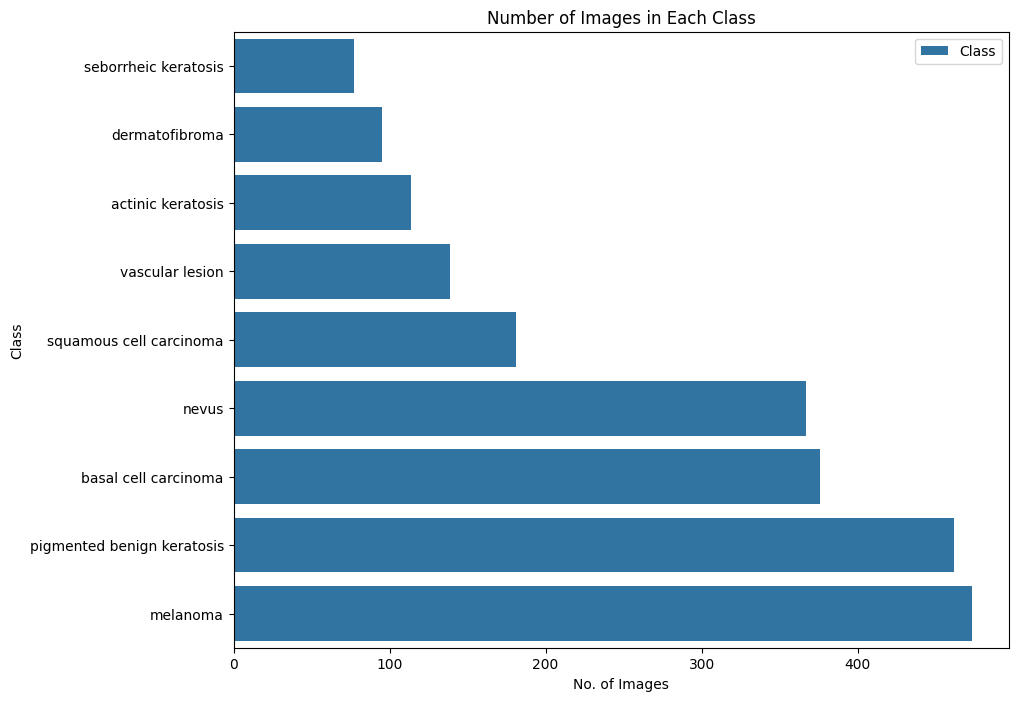

In [9]:
# Visualize the Number of Images in Each Class

# Import the seaborn library for data visualization
import seaborn as sns

# Set the size of the plot figure
plt.figure(figsize=(10, 8))

# Create a bar plot using seaborn
# x-axis: Number of Images
# y-axis: Class names
# Data source: df DataFrame
# Label: "Class"
sns.barplot(x="No. of Images", y="Class", data= class_distribution_df, label="Class")

# Add a title to the plot
plt.title("Number of Images in Each Class")

# Display the plot
plt.show()

**Observations:** We have class impalance. In next step we will be handling class imbalance

## Handling class imbalances

In [10]:
# Install Augmentor library
!pip install -q Augmentor

# Define the path to the training dataset
path_to_training_dataset = "/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

# Import the Augmentor library
import Augmentor

# Loop through each class and perform data augmentation
for i in class_names:
    # Create an Augmentor pipeline for the current class
    p = Augmentor.Pipeline(path_to_training_dataset + i)

    # Apply rotation augmentation with specified parameters
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

    # Generate and save 500 augmented samples for each class
    p.sample(500)  # Adding 500 samples per class to ensure class balance

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B55FD9E4400>: 100%|██████████| 500/500 [00:20<00:00, 24.61 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B55A411A890>: 100%|██████████| 500/500 [00:20<00:00, 23.90 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B55F3C528C0>: 100%|██████████| 500/500 [00:19<00:00, 25.99 Samples/s]


Initialised with 473 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7B55F2804970>: 100%|██████████| 500/500 [01:28<00:00,  5.68 Samples/s]


Initialised with 367 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7B55A3F95600>: 100%|██████████| 500/500 [01:18<00:00,  6.41 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B55A4208B50>: 100%|██████████| 500/500 [00:19<00:00, 25.84 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B55FDAC5000>: 100%|██████████| 500/500 [00:39<00:00, 12.54 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B55F27689A0>: 100%|██████████| 500/500 [00:18<00:00, 26.40 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B55F27AF7C0>: 100%|██████████| 500/500 [00:18<00:00, 26.52 Samples/s]


In [11]:
# Count the Total Number of Augmented Images Generated by Augmentor

# Count the number of image files in the 'output' subdirectories of each class
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))

# Print the total count of augmented images
print("Total number of augmented images:", image_count_train)

Total number of augmented images: 4500


## Model building and training

In [12]:
#Model Building

# Create a Training Dataset

# Use image_dataset_from_directory() to create a training dataset from the training directory
# Batch size: 32 images per batch
# Image size: 180x180 pixels
# Label mode: 'categorical' for one-hot encoded class labels
# Seed: 123 for random shuffling consistency
# Subset: "training" to select the training subset of the dataset
# Validation split: 20% of the data is used for validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=32, image_size=(180, 180), label_mode='categorical',
    seed=123, subset="training", validation_split=0.2
)

# Note: With label_mode set to 'categorical', the labels are represented as a float32 tensor
# of shape (batch_size, num_classes), where each label is a one-hot encoding of the class index.

Found 6784 files belonging to 9 classes.
Using 5428 files for training.


In [13]:
# Create a Validation Dataset

# Use image_dataset_from_directory() to create a validation dataset from the training directory
# Batch size: 32 images per batch
# Image size: 180x180 pixels
# Label mode: 'categorical' for one-hot encoded class labels
# Seed: 123 for random shuffling consistency
# Subset: "validation" to select the validation subset of the dataset
# Validation split: 20% of the data is used for validation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=32, image_size=(180, 180), label_mode='categorical',
    seed=123, subset="validation", validation_split=0.2
)

Found 6784 files belonging to 9 classes.
Using 1356 files for validation.


In [14]:
# Define the appropriate number of processes that are free for working using AUTOTUNE
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Cache the training dataset in memory after loading images from disk during the first epoch
# This helps improve data loading speed for subsequent epochs
train_ds = train_ds.cache()

# Shuffle the training dataset to introduce randomness during training
# and prevent the model from memorizing the order of examples
train_ds = train_ds.shuffle(1000)

# Prefetch data for training to overlap data preprocessing and model execution
# This can lead to better GPU utilization and overall training performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

# Cache the validation dataset in memory
# Caching the validation data can help improve evaluation speed
val_ds = val_ds.cache()

# Prefetch data for validation
# Similar to training, prefetching can enhance validation performance
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

## CNN Model 

In [15]:
# CNN Model Architecture

# Sequential allows you to create models layer-by-layer
model = Sequential()

# Rescaling Layer: Scale input pixel values to the [0, 1] range
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)))

# First Convolutional layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Dropout layer with 50% Fraction of the input units to drop
model.add(layers.Dropout(0.5))

# Flatten Layer: Convert multi-dimensional input tensors into a single dimension
model.add(layers.Flatten())

# Dense Layer: Fully connected layer with 128 units and ReLU activation
model.add(layers.Dense(128, activation='relu'))

# Dropout layer with 25% Fraction of the input units to drop
model.add(layers.Dropout(0.25))

# Dense Layer with softmax activation function
# Softmax scales logits into probabilities
model.add(layers.Dense(len(class_names), activation='softmax'))

# Display model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

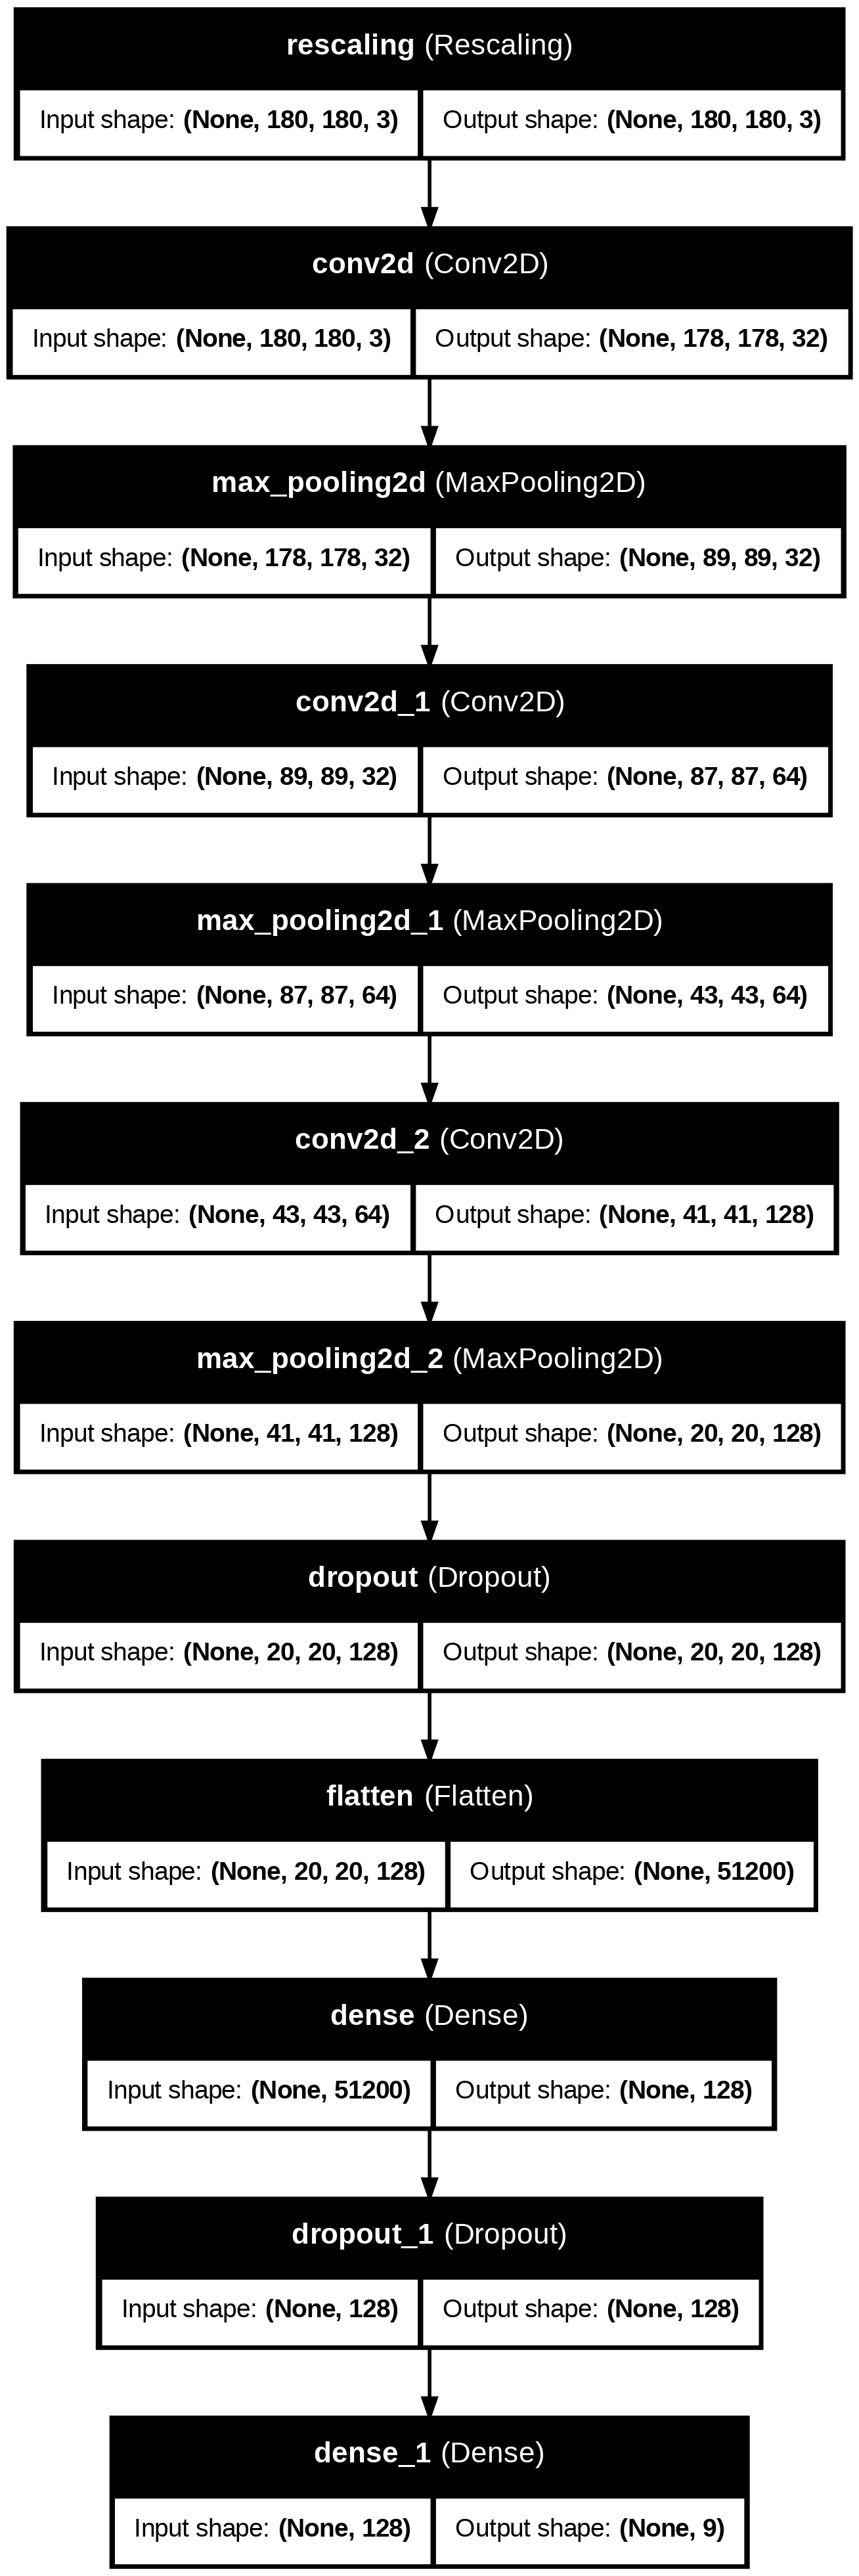

In [16]:
# Visualizing the Model Architecture

# Import the necessary function from TensorFlow Keras utilities
from tensorflow.keras.utils import plot_model

# Plot the model architecture and save it as an image file
# Set show_shapes=True to display the shapes of the input/output tensors in the plot
# Set show_layer_names=True to display the names of the layers in the plot
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
# Compile the Model

# Compile the model with Adam optimization
# Adam is a stochastic gradient descent method with adaptive estimation of moments
# Categorical crossentropy is used as the loss function for multi-class classification
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

# ModelCheckpoint callback is used to save the model or weights at specific intervals
# It saves the best model based on the validation accuracy
# The saved model can be loaded later to continue training from the saved state
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# EarlyStopping callback is used to stop training when a monitored metric stops improving
# It helps prevent overfitting by stopping training when validation accuracy plateaus
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

## Model training with epochs 30

In [18]:

# Train the Model

# Set the number of training epochs
epochs = 30

# Train the model using the training dataset and validate on the validation dataset
# Use the ModelCheckpoint and EarlyStopping callbacks defined earlier
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[checkpoint, earlystop])

Epoch 1/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2010 - loss: 2.1381
Epoch 1: val_accuracy improved from -inf to 0.42625, saving model to model.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 63s 118ms/step - accuracy: 0.2014 - loss: 2.1366 - val_accuracy: 0.4263 - val_loss: 1.5525
Epoch 2/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4070 - loss: 1.5324
Epoch 2: val_accuracy did not improve from 0.42625
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4070 - loss: 1.5324 - val_accuracy: 0.4019 - val_loss: 1.5579
Epoch 3/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4788 - loss: 1.3867
Epoch 3: val_accuracy improved from 0.42625 to 0.48378, saving model to model.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.4789 - loss: 1.3865 - val_accuracy: 0.4838 - val_loss: 1.3420
Epoch 4/30
169/170 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5628 - loss: 1.1973
Epoch 4: val_accuracy improved from 0.48378 to 0.56047, saving model to model.ke

## Plotting training Curve

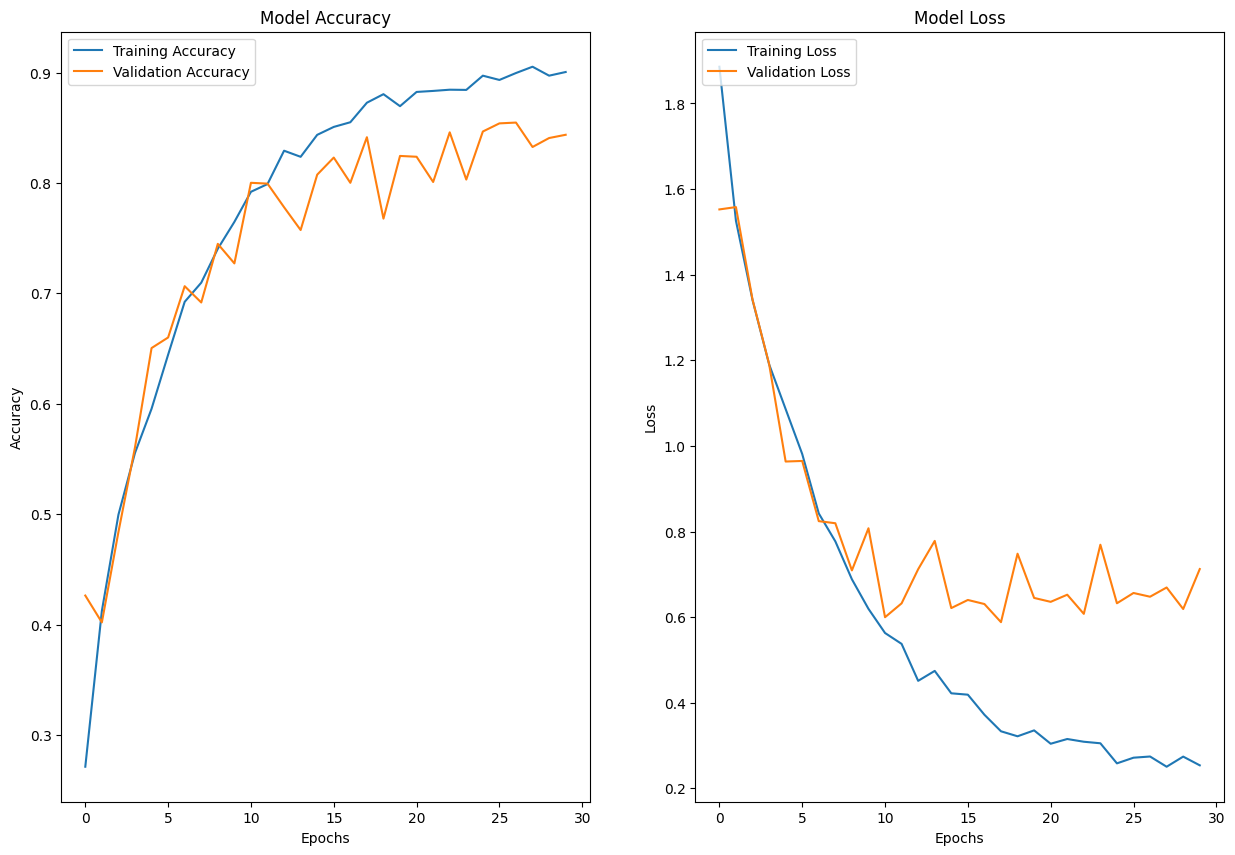

In [21]:
# Plot the Training Curves

# Get the range of epochs where training was stopped by EarlyStopping
epochs_range = range(len(history.history['accuracy']))

# Create a figure with two subplots for accuracy and loss
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

# Plot Model Accuracy
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper left')

# Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper left')

# Display the plots
plt.show()

**Observations:** <br>1.The validation accuracy improved consistently with each epoch, peaking at around 90.67%.<br>
2.Validation loss decreased as the model learned, highlighting its ability to generalize well on unseen data. <br>
3.The model demonstrated strong generalization, as evidenced by the consistent improvement in validation accuracy and reduction in validation loss. <br>
4.These results suggest that the model effectively learned relevant features from the training data and successfully applied them to new images.

## Model evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


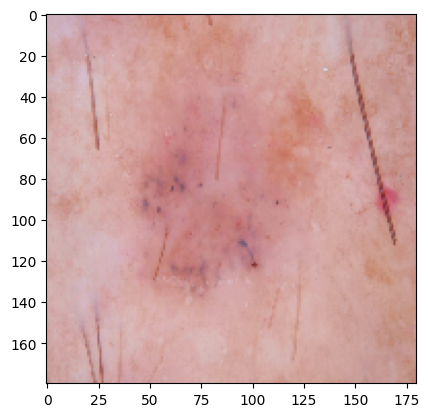

In [28]:
#Evaluate model on one of test instance

from glob import glob

# Construct the path to a test image
test_image_path = os.path.join(data_dir_test, class_names[1], '*')

# Get a list of all test images for the selected class
test_images = glob(test_image_path)

# Load the last test image in the list
test_image = load_img(test_images[2], target_size=(180, 180, 3))

# Display the test image
plt.imshow(test_image)
plt.grid(False)

# Expand dimensions to match the input shape of the model
img = np.expand_dims(test_image, axis=0)

# Make predictions using the trained model
pred = model.predict(img)

# Get the index of the predicted class with the highest probability
pred = np.argmax(pred)

# Get the predicted class name
pred_class = class_names[pred]

# Print the actual and predicted class names
print("Actual Class: " + class_names[1])
print("Predicted Class: " + pred_class)